<a href="https://colab.research.google.com/github/sachaRfd/Chemistry-Related-notebooks/blob/main/LSTM_Compound_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Recurent Neural Network to generate new SMILES (String format of Chemical Compounds):

Project Brief:

I want to create and train RNNs to be able to generate theoretically pheasible chemical compounds. For this I will be trying to implement LSTMs as they have been shown to produce SMILES (String-form representations of chemicals) quite well.

Here are some Examples of Chemicals generated by my model with increasing complexity (temperature) settings:

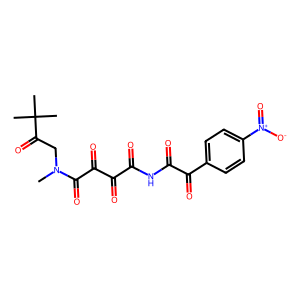

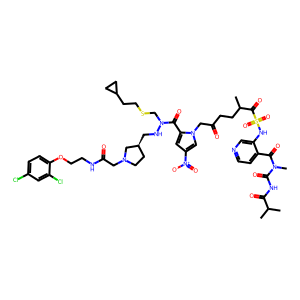

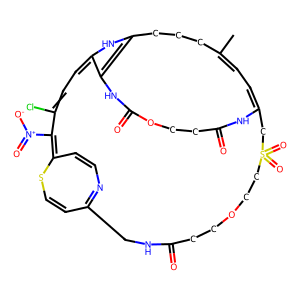

Classic Imports:

In [1]:
import torch
import torch.nn as nn
import string
import random
import sys
import os
import pandas as pd
import numpy as np

!pip install unidecode
import unidecode
from torch.utils.tensorboard import SummaryWriter

!pip install rdkit -q

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 13.3 MB/s 
     |████████████████████████████████| 29.3 MB 1.2 MB/s 
Mounted at /content/drive


In [2]:
# Get characters: 
all_characters = string.printable
n_characters = len(all_characters)
print(all_characters)
print(n_characters)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

100


## Downloading the data from ZINC: 

Zinc is a great place to find chemical compound SMILES:

http://files.docking.org/2D/

In [3]:
shard = "EEBD"
os.system(f"mkdir -pv {shard[0:2]} && wget -c http://files.docking.org/2D/{shard[0:2]}/{shard}.smi -O {shard[0:2]}/{shard}.smi")
DF = pd.read_csv('EE/EEBD.smi', sep = " ")  # In the File, the Smiles and Zinc_ids are seperated by a space
DF.drop(columns='zinc_id', inplace=True)  # Dont currently need the Zinc ID column
DF

,smiles
0,O=C(COc1ccccc1[N+](=O)[O-])OCc1ccc2c(c1)OCO2
1,CN(CCc1ccccn1)C(=O)CCNc1ccccc1[N+](=O)[O-]
2,Cc1ocnc1C(=O)OCC1CCN(c2ccc([N+](=O)[O-])cn2)CC1
3,CSCC[C@@H]1NC(=S)N([C@@H](C)c2cccc([N+](=O)[O-...
4,Cc1ccc([N+](=O)[O-])cc1NC(=O)CN1CCC(NC(C)C)CC1
...,...
426480,Cc1ncn(C)c1C(=O)N1CCC(Nc2ccc([N+](=O)[O-])cc2)CC1
426481,Cc1ncncc1C(=O)NC1CCN(c2ccc([N+](=O)[O-])cc2)CC1
426482,O=C(N[C@H]1CC[C@H](Nc2ccccc2[N+](=O)[O-])CC1)c...
426483,O=C(NCC1CC2(C1)OCCO2)c1cccc(Cl)c1[N+](=O)[O-]


Let's now save DF dataframe as a txt file: 

In [4]:
DF.to_csv(r'SMILES.txt', header=None, index=None, sep=' ', mode='a')

In [5]:
DF.smiles

0              O=C(COc1ccccc1[N+](=O)[O-])OCc1ccc2c(c1)OCO2
1                CN(CCc1ccccn1)C(=O)CCNc1ccccc1[N+](=O)[O-]
2           Cc1ocnc1C(=O)OCC1CCN(c2ccc([N+](=O)[O-])cn2)CC1
3         CSCC[C@@H]1NC(=S)N([C@@H](C)c2cccc([N+](=O)[O-...
4            Cc1ccc([N+](=O)[O-])cc1NC(=O)CN1CCC(NC(C)C)CC1
                                ...                        
426480    Cc1ncn(C)c1C(=O)N1CCC(Nc2ccc([N+](=O)[O-])cc2)CC1
426481      Cc1ncncc1C(=O)NC1CCN(c2ccc([N+](=O)[O-])cc2)CC1
426482    O=C(N[C@H]1CC[C@H](Nc2ccccc2[N+](=O)[O-])CC1)c...
426483        O=C(NCC1CC2(C1)OCCO2)c1cccc(Cl)c1[N+](=O)[O-]
426484                CC1(CCNc2ncc([N+](=O)[O-])cc2Br)OCCO1
Name: smiles, Length: 426485, dtype: object

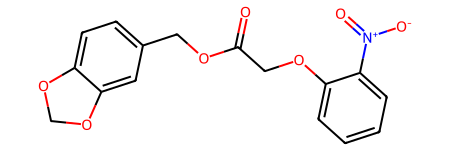

In [6]:
Chem.MolFromSmiles(DF.smiles[0])

## Now that we have the text file ready, let's get to the RNN modelling:
- First read the file and make sure everything is in ASCII format: 

In [7]:
file = unidecode.unidecode(open('SMILES.txt').read())

### Now implement our LSTM, we will start by creating an nn.Module for our LSTM:

- Applying a linear 
- Applying a linear
- Applying a .

In [8]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(RNN, self).__init__()
    
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # Create embedding for each character that will be learned by the model: 
    self.embed = nn.Embedding(input_size, hidden_size)
    self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  
  def forward(self, x, hidden, cell):
    out = self.embed(x)
    out, (hidden, cell) = self.lstm(out.unsqueeze(1), (hidden, cell))  # make shape match
    out = self.fc(out.reshape(out.shape[0], -1))  # unrolls the shape
    return out, (hidden, cell)
  

  def init_hidden(self, batch_size):
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    return hidden, cell

### Now to implement the LSTM class, let's create a LSTM generator class which will: 

- Applying a linear 
- Applying a linear
- Applying a .

In [10]:
class LSTM_Generator(nn.Module):
  def __init__(self):
    super(LSTM_Generator, self).__init__()


    self.chunk_len = 250  # How many characters will it take at a time from the file
    self.epochs = 1000
    self.batch_size = 1  # Was seen to be good at 1
    self.print_every = 200  # Number of epochs when Loss is printed to screen during training
    self.hidden_size = 256
    self.num_layers = 2
    self.lr = 0.003

  
  def char_tensor(self, string): 
    '''Take character and map it to the index in the all characters list'''
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
      tensor[c] = all_characters.index(string[c])
    
    return tensor

  def get_random_batch(self):
    start_idx = random.randint(0, len(file) - self.chunk_len)  # makes sure its always in the chunk length
    end_idx = start_idx + self.chunk_len + 1  # python indexing need to add 1
    text_str = file[start_idx:end_idx]
    text_input = torch.zeros(self.batch_size, self.chunk_len)
    text_target = torch.zeros(self.batch_size, self.chunk_len)

    for i in range(self.batch_size):
      # We want the model to predict the following characters from the first character
      text_input[i,:] = self.char_tensor(text_str[:-1])  # dont take last character as we dont want any other predictions
      text_target[i,:] = self.char_tensor(text_str[1:])  # dont take the first character as we want to predict from it

    return text_input.long(), text_target.long()


  def generate(self, initial_str='O', prediction_len=100, temperature=0.85):  # Temperature --> risk of the RNN generation 0 is very conservative and towards 1 is risky character generation
    hidden, cell = self.rnn.init_hidden(batch_size = self.batch_size)
    initial_input = self.char_tensor(initial_str)  # convert string to tensor
    predicted = initial_str

    for p in range(len(initial_str) - 1):  # have -1 as we are building up the hidden and cell state to not include the last character in the string 
      _, (hidden, cell) = self.rnn(initial_input[p].view(1).to(device), hidden, cell)  # dont care about the prediction, just the hidden and cell
    # View is just to add additional axis to make tensors fit
    last_char = initial_input[-1]

    # Getting predictions:
    for p in range(prediction_len):
      output, (hidden, cell) = self.rnn(last_char.view(1).to(device), hidden, cell)  # dont care about the prediction, just the hidden and cell
      output_dist = output.data.view(-1).div(temperature).exp()  # Unroll with view - 1, divide by temperature and take exponential  --> Add the riskiness
      top_char = torch.multinomial(output_dist, 1)  # Take the highest probability character / but randomised with torch.multinomial
      predicted_char = all_characters[top_char]  # gets the charcter from list of characters and index
      predicted += predicted_char
      last_char = self.char_tensor(predicted_char)
    
    return predicted


  
  def train(self):
    self.rnn = RNN(n_characters, self.hidden_size, self.num_layers, n_characters).to(device)

    optimizer = torch.optim.Adam(self.rnn.parameters(), lr = self.lr)
    criterion = nn.CrossEntropyLoss()
    writer = SummaryWriter(f'runs/text0')  # for tensorboard
    print('Starting Training --> ')

    for epoch in range(1, self.epochs + 1):
      inp, target = self.get_random_batch()
      hidden, cell = self.rnn.init_hidden(batch_size = self.batch_size)

      self.rnn.zero_grad()
      loss = 0  # set to 0
      inp = inp.to(device)
      target = target.to(device)

      for c in range(self.chunk_len):
        output, (hidden, cell) = self.rnn(inp[:, c], hidden, cell)
        loss += criterion(output, target[:, c])

      loss.backward()
      optimizer.step()
      loss = loss.item() / self.chunk_len  # to get average loss

      if epoch % self.print_every == 0: 
        print(f'Epoch Number {epoch}')  # Prints Epoch Number
        print()
        print(f'Loss: {loss}')  # Prints the Loss to Screen
        print()
        test = self.generate(initial_str='O', prediction_len=100, temperature=0.85)  # Generate a couple Samples
        Potential_Smiles_list = [line.strip() for line in test.split('\n')]  # Get list of the generated Samples
        List_of_Molecules = np.array([Chem.MolFromSmiles(s) for s in Potential_Smiles_list])  # List of generated samples where if sample is not real Molecule, you get None
        print(f"Percentage of Generated Compounds which are invalid: {(List_of_Molecules == None).sum()/len(List_of_Molecules)}")
        print()
        print()
      writer.add_scalar('Training Loss', loss, global_step=epoch)  # For tensor Board

model = LSTM_Generator()
model.train()

Starting Training --> 
Epoch Number 500

Loss: 0.701646240234375

Percentage of Generated Compounds which are invalid: 1.0


Epoch Number 1000

Loss: 0.5842034912109375

Percentage of Generated Compounds which are invalid: 0.5




## Now let's Sample examples from our generative LSTM: 

For Comparison Below is an Example from our training dataset: 

String for compound below is: O=C(COc1ccccc1[N+](=O)[O-])OCc1ccc2c(c1)OCO2


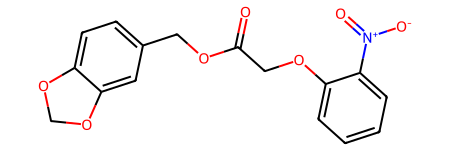

In [11]:
print(f'String for compound below is: {DF.smiles[0]}')
Chem.MolFromSmiles(DF.smiles[0])

Now let's get examples from our Model: 

Let's try putting the created smiles in a list and check if they're real compounds: 

In [29]:
samples = (model.generate(initial_str='C', prediction_len=10000, temperature=0.99))  # Let's Make the compounds start with a Carbon, and make the samples ' Risky'
samples

'C(=O)N2CCCN(c3ccc([N+](=O)[O-])cc2F)C1\nCc1cc(Nc3cc3ccc([N+](=O)[O-])c(Cl)cc2)n1\nCOCCN(Cc1cc([C@@H](C)C(=O)Nc2cccc([N+](=O)[O-])c2)n(-c2ccccc2[N+](=O)[O-])s1\nCc1cc([C@H](NC(=O)c2ccc([N+](=[O-])ccc3n2)cc1\nCC(C)CC1CC(CNC(=O)c2nccc([N+](=O)[O-])cc23)CC1\nCCOC(=O)c1ccc(N3CCCSC[C@H]3Nc3cccnc3c2ccc([N+](=O)[O-])c2c1\nCCC[C@H](NS(=O)(=O)c1cccc([N+](=O)[O-])n1)N[C@H]1CCCN11\nCC(=O)[C@H](C)C(=O)N1CCc2ccc([N+](=O)[O-])cc2)n1)c1cccc2\nC[C@H]1CCN(C(=O)c2ccc([N+](=O)[O-])c1)C1CC1(C)C\nCc1cc(/C=C/CCNC(=O)C(=O)c2ccc([N+](=O)[O-])cc2F)C[C@H](C\nCc1ccc([N+](=O)[O-])c(NC[C@H]2CCC2)C1\nCc1c([C@H]2c1[nH]ccc1[C@H](NC(=O)C(=O)CCn2cccc2)[C@@H](C(=O)O)ccc1NC(=O)CN(C)C[C@H](C)C[C@@](C)(C)CC(=O)N[C@](C)(Cc2ccnc(Cl)cc2)c([N+](=O)[O-])cc1l\nCn1ccc(NC(=O)c2cccc(F)c(CNC(=O)(=O)N(C)CCCOc3c2cccc(Cl)c2)CN(Nc2cc([N+](=O)[O-])o1)c1cccccn1\nCOc1ccc([N+](=O)[O-])c(N2CCO[C@@H]3CCCCO4)CC2)C1\nCOC(=O)C(c1ccc([N+](=O)[O-])cc1-c1cccc(-c2nnn2)c(-c3nn[nH]n2)ccc1\nCc1c(C(=O)N[C@H]2[C@H]2CCCOCC2)C1\nCSCCC(=O)C(C)(=O)Nc1ccccc1[

As you can see the Generated list of Smiles are continuous but seperated by \n to indicate the end of the Smiles. Let's Seperate each generated smile into a list: 

In [30]:
Potential_Smiles_list = [line.strip() for line in samples.split('\n')]
print(f'We have Generated {len(Potential_Smiles_list)} Potential Smiles.')

We have Generated 153 Potential Smiles.


Now let's see how many of the generated SMILES correspond to real potential Molecules: 

In [31]:
# Apply the CHEM.MOLFromSmiles function from RDKIT
List_of_Molecules = np.array([Chem.MolFromSmiles(s) for s in Potential_Smiles_list])

Then we can calculated the amount of invalid Smiles we have created: 

In [32]:
print("Percentage of Invalid Generated Compounds: ")
(List_of_Molecules == None).sum()/len(List_of_Molecules)

Percentage of Invalid Generated Compounds: 


0.9411764705882353

Great, our model has generated some new compounds. Before we visualise them, we need to create a new list of smiles, with only real molecules in it: 

In [33]:
List_of_REAL_Molecules = List_of_Molecules[(List_of_Molecules != None)]
smiles_list = [Chem.MolToSmiles(mol) for mol in List_of_REAL_Molecules]

Let's See how may real molecules our model has Generated: 

In [34]:
print(f'We have Generated {len(smiles_list)} real compounds.')

We have Generated 9 real compounds.


Now we should be able to visualise the Smiles we have created: 

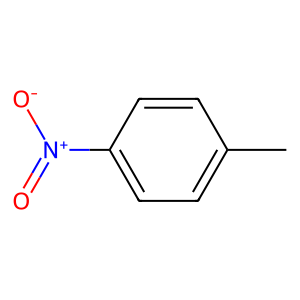

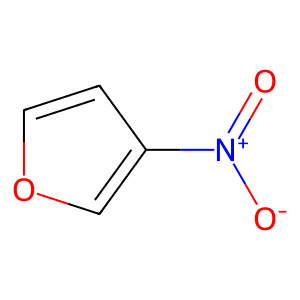

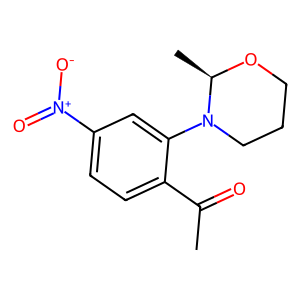

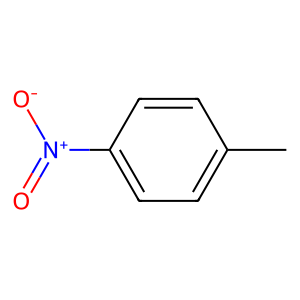

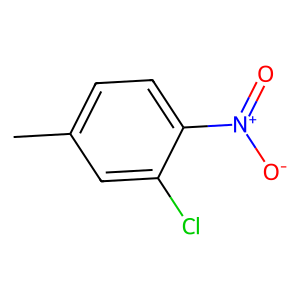

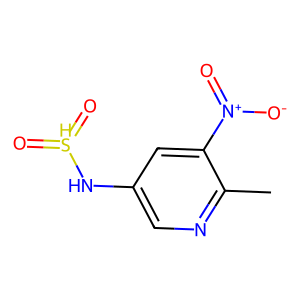

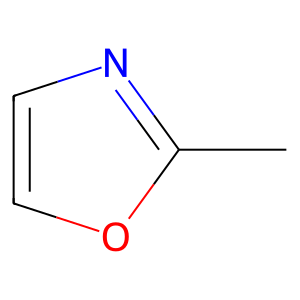

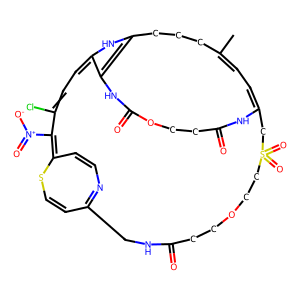

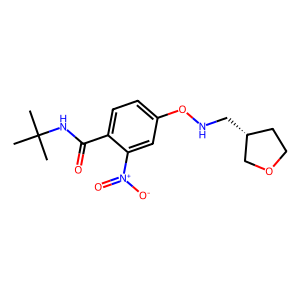

In [35]:
from IPython.display import display

for i, smiles in enumerate(smiles_list):  # Iterate over the list of SMILES strings
  mol = Chem.MolFromSmiles(smiles)  # Convert the SMILES string to an RDKIT Mol object
  img = Chem.Draw.MolToImage(mol)  # Generate an image of the molecule
  display(img)  # Display the image in the notebook


Let's save the Molecules as PNG images:

In [36]:
for i, smiles in enumerate(smiles_list):  # Iterate over the list of SMILES strings
  mol = Chem.MolFromSmiles(smiles)  # Convert the SMILES string to an RDKIT Mol object
  img = Chem.Draw.MolToImage(mol)  # Generate an image of the molecule
  img.save(f'mol_{i}.png')  # Save the image to a file
  

Now Let's check to see if the molecules we have created are from data-leakage of the training dataset: 

In [37]:
# Check if the generated SMILES strings are contained in the 'smiles' column of the training dataframe
mask = DF['smiles'].isin(smiles_list)

filtered_df = DF[mask]  # Extract the rows of the dataframe that contain the generated SMILES strings

filtered_df

,smiles


In [38]:
print(f'{filtered_df.shape[0]} Compounds come from Data Leakage from the training set.')

0 Compounds come from Data Leakage from the training set.
